# **AI Model for Identifying Emotional States from Speech**

**This AI system recognizes emotions by analyzing vocal patterns. It is trained on high-quality emotional speech datasets contributed by professional actors, enabling accurate classification of emotional states like happiness, anger, and sadness and many more.**

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU Found')
    !nvidia-smi
else:
    print("GPU not Found")

GPU Found
Mon May 19 05:57:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             26W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------------------

I0000 00:00:1747634226.120366      35 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747634226.120608      35 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # Should list both GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


### DATASET 
#### 🔹 TESS (Toronto Emotional Speech Set)  
📌 **Link**: [TESS on Kaggle](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)  
📄 **Description**:  
- 2 actresses (older adult female voices)  
- 200 target words spoken in 7 emotions: *anger, disgust, fear, happiness, pleasant surprise, sadness, neutral*  
- Clean, well-structured dataset  
- Useful for studying emotional variation in older female speech

# 1. Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

# 2. Load the Dataset

In [6]:
import os

tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
tess_dir = os.listdir(tess)
emotions = []
filepath = []
for dir in tess_dir:
    folder = os.listdir(tess+dir)
    for audio in folder:
        #print(audio)
        audio_description = audio.split(".")[0]
        file = audio_description.split("_")
        if file[2] == "ps":
            emotions.append("Surprise")
        else:
            emotions.append(file[2])
        filepath.append(tess+dir+"/"+audio)
    # Limiting to 2800 audio files to avoid duplicates present in the dataset,which may cause errors during training or evaluation
    if len(filepath)==2800:
        break
print("Datasets are loaded")
print("Total audio files loaded:", len(filepath))


Datasets are loaded
Total audio files loaded: 2800


In [7]:
filepath[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [8]:
emotions[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

# 3. Creating a dataframe

In [9]:
df=pd.DataFrame()
df['audio_paths']=filepath
df['Emotions']=emotions
df.head()

,audio_paths,Emotions
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [10]:
df['Emotions'].value_counts()

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
Surprise    400
happy       400
Name: count, dtype: int64

# 4. Data Analysis

<Axes: xlabel='Emotions', ylabel='count'>

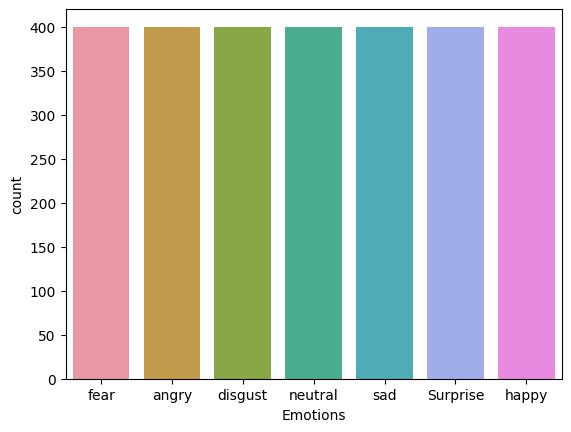

In [11]:
sns.set_palette("summer")
sns.countplot(data=df, x="Emotions")

# 5. Visualizing Waveform and Spectrogram for Emotion

In [12]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

## 5.1   Fear

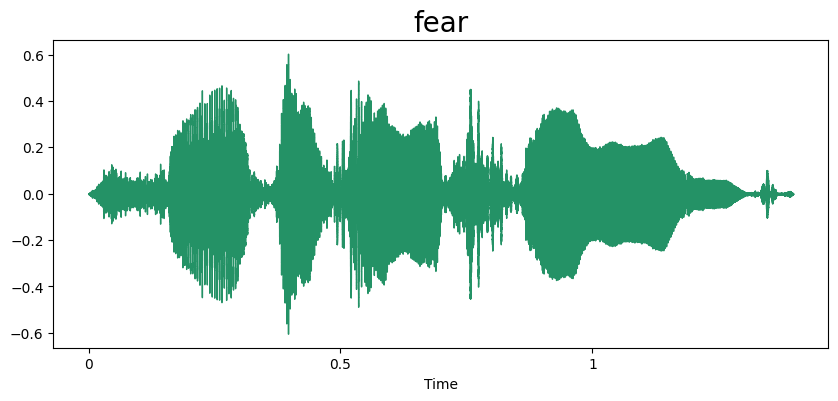

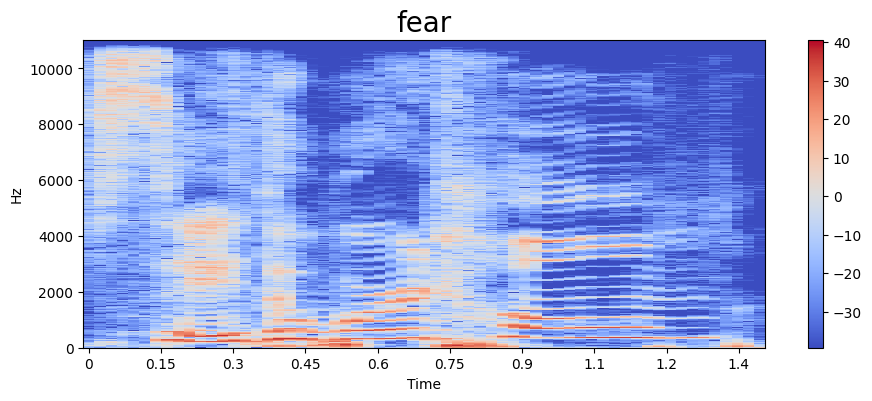

In [13]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.2 Angry

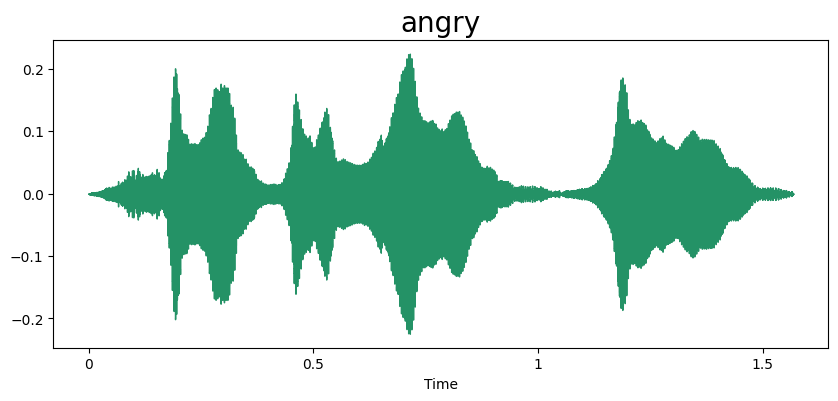

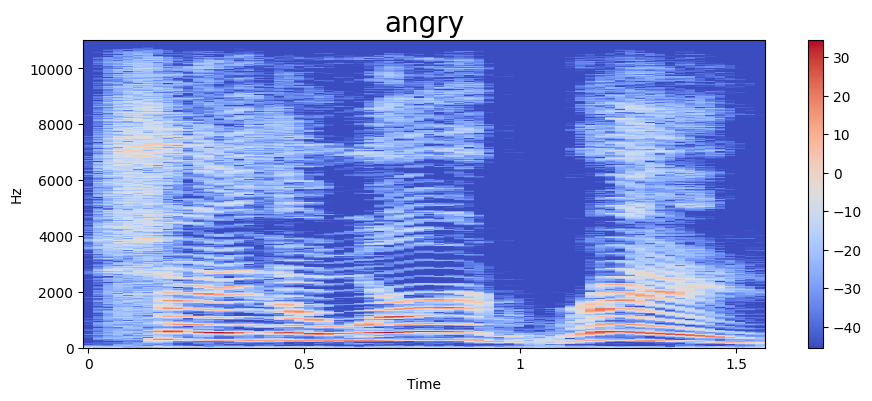

In [14]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.3 Neutral

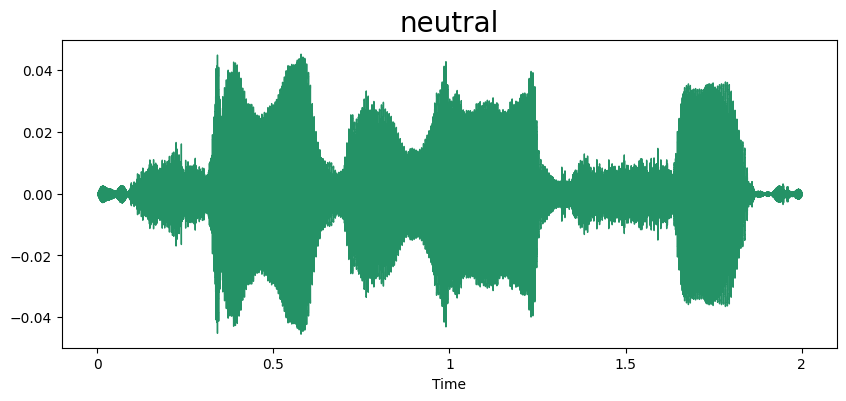

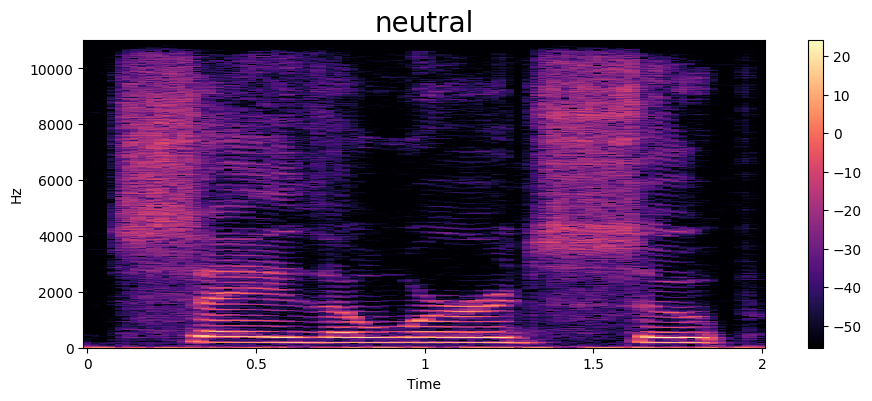

In [15]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.4 Sad

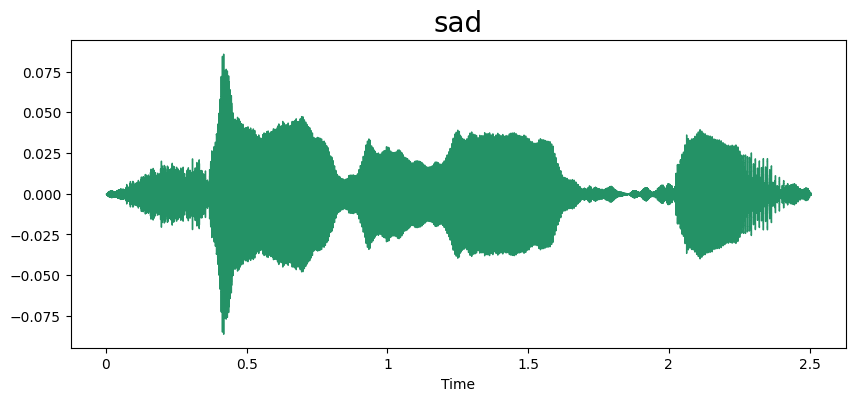

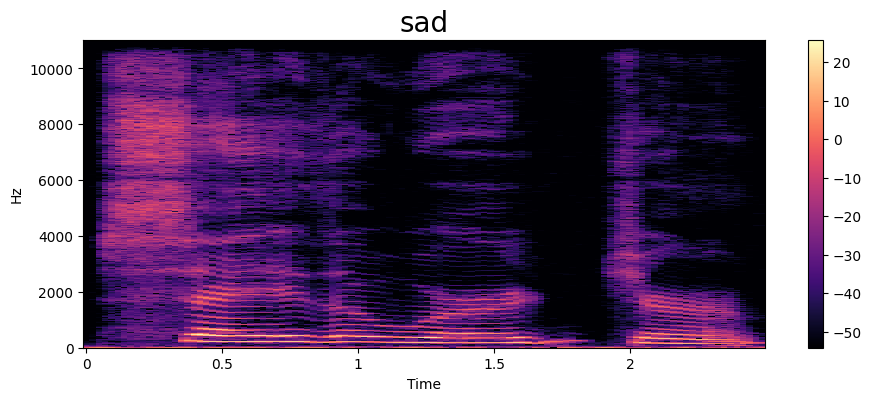

In [16]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.5 Happy

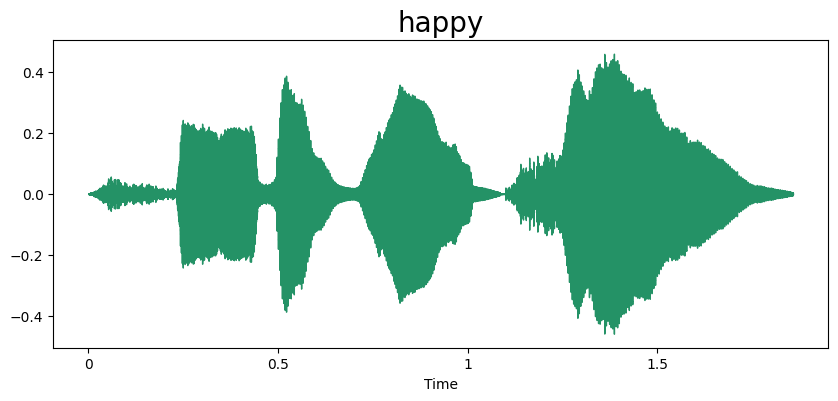

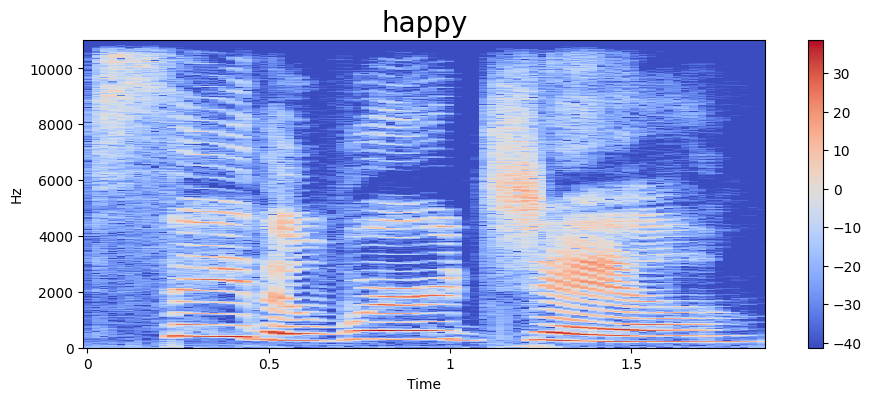

In [17]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.6 Surprise

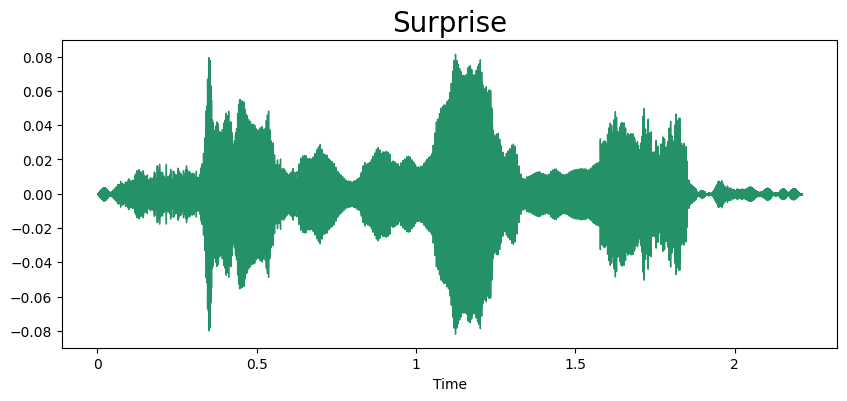

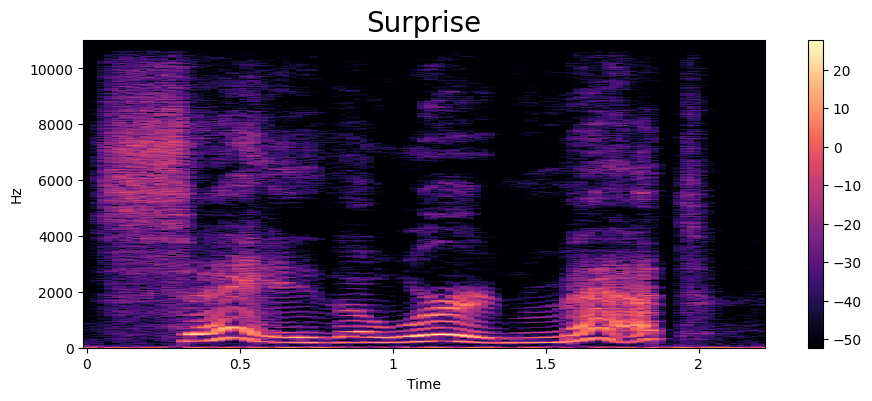

In [18]:
emotion = 'Surprise'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## 5.7 Disgust

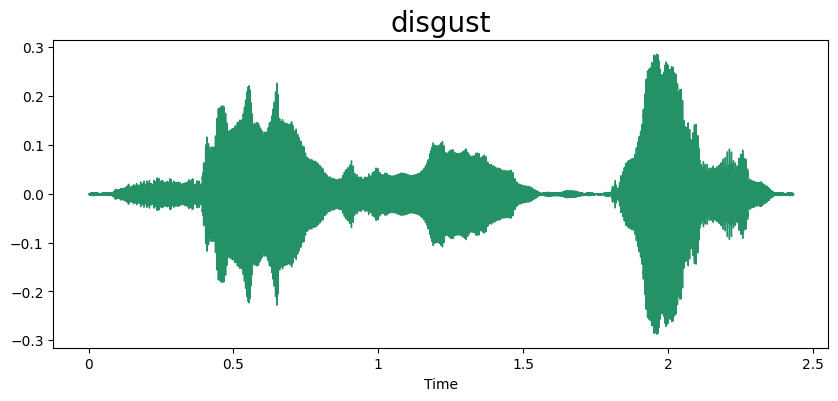

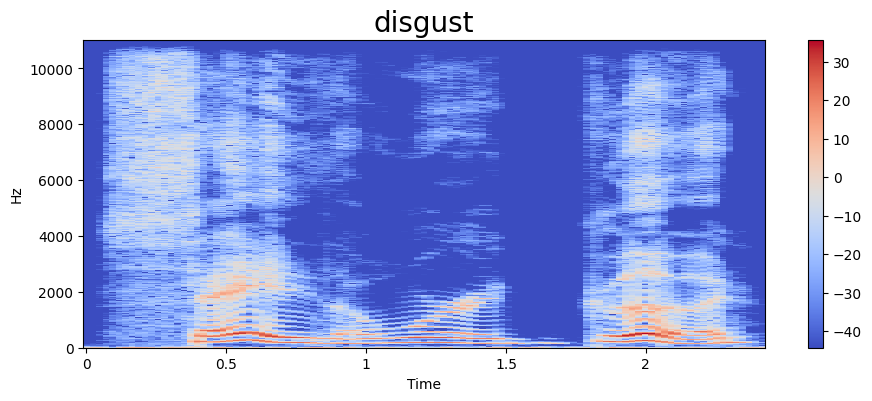

In [19]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['Emotions'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# 6. Create Custom Dataset Class

In [20]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['Emotions'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['Emotions'] = df['Emotions'].map(label_map)
df.head(5)

,audio_paths,Emotions
0,/kaggle/input/toronto-emotional-speech-set-tes...,0
1,/kaggle/input/toronto-emotional-speech-set-tes...,0
2,/kaggle/input/toronto-emotional-speech-set-tes...,0
3,/kaggle/input/toronto-emotional-speech-set-tes...,0
4,/kaggle/input/toronto-emotional-speech-set-tes...,0


# 7. Model

In [21]:
from torch.utils.data import Dataset
import torchaudio

class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=44100):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['Emotions']
        
        # Load the audio file
        speech, sr = librosa.load(audio_path,sr=16000)

        # Pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')
        # Preprocess the audio using a Hugging Face processor
        inputs = self.processor(
            speech,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            truncate=True,
            max_length=self.max_length
        )
    
        input_values = inputs.input_values.squeeze()
    
        return {
            'input_values': input_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [22]:
# Split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [23]:
# Initialize the processor and model
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
# Replace `num_labels` with the number of emotion classes you have
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-base',
    num_labels=7  # Example: 7 emotion classes (like Happy, Sad, Angry, etc.)
)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [24]:
# Load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [25]:
# Create dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 8. Set Training Argument

In [26]:
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
training_args = TrainingArguments(
    output_dir='./results',
    save_strategy='epoch',
    eval_steps=500,  # Evaluate every 500 steps (adjust as needed)
    logging_steps=500,  # Optional: log metrics every 500 steps
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)


print("TrainingArguments initialized successfully.")


TrainingArguments initialized successfully.


In [27]:
import transformers
print(transformers.__version__)

4.51.3


In [28]:
# Create functions for computing metrics
def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [29]:
# initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


Step,Training Loss


TrainOutput(global_step=210, training_loss=0.9535480317615327, metrics={'train_runtime': 637.9202, 'train_samples_per_second': 10.534, 'train_steps_per_second': 0.329, 'total_flos': 1.68156718632e+17, 'train_loss': 0.9535480317615327, 'epoch': 3.0})

In [30]:
results=trainer.evaluate()
print(results)

{'eval_loss': 0.41449734568595886, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 13.2719, 'eval_samples_per_second': 42.194, 'eval_steps_per_second': 1.356, 'epoch': 3.0}


# 9. Test Predictions

In [31]:
import random
idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')
with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits
predicted_class = logits.argmax(dim=1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original Label: disgust
Predicted Label: disgust


In [32]:
idx = random.randrange(0, len(test_dataset))
print('Original Label:', inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original Label: fear
Predicted Label: fear


In [34]:
idx = random.randrange(0, len(test_dataset))
print('Original Label:', inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: happy


In [40]:
from sklearn.metrics import classification_report
import torch
from tqdm import tqdm

# Step 1: Collect true labels and predictions
true_labels = []
pred_labels = []

model.eval()
model.to("cuda")

for batch in tqdm(test_dataloader):
    input_values = batch["input_values"].to("cuda")
    labels = batch["labels"].to("cuda")

    with torch.no_grad():
        outputs = model(input_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())

# Step 2: Map integer labels to emotion names
emotion_names = [inverse_label_map[i] for i in sorted(inverse_label_map.keys())]

# Step 3: Print classification report
print(classification_report(true_labels, pred_labels, target_names=emotion_names))


100%|██████████| 70/70 [00:12<00:00,  5.58it/s]

              precision    recall  f1-score   support

        fear       1.00      1.00      1.00        89
       angry       1.00      1.00      1.00        86
     disgust       1.00      1.00      1.00        74
     neutral       1.00      1.00      1.00        69
         sad       1.00      1.00      1.00        89
    Surprise       1.00      1.00      1.00        70
       happy       1.00      1.00      1.00        83

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



# 10. Plots

In [45]:
# Convert log history to a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)
# Show all available columns
print(log_history.columns)
# Drop entries that don't contain loss/accuracy
log_df = log_history.dropna(subset=["train_loss", "eval_loss"], how="all")
# Display a few rows
log_df.head()

Index(['train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss', 'epoch', 'step', 'eval_loss',
       'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second'],
      dtype='object')


,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,637.9202,10.534,0.329,1.681567e+17,0.953548,3.0,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,3.0,210,0.414497,1.0,1.0,1.0,1.0,13.2719,42.194,1.356


## 10.1 Training and Evaluation Loss

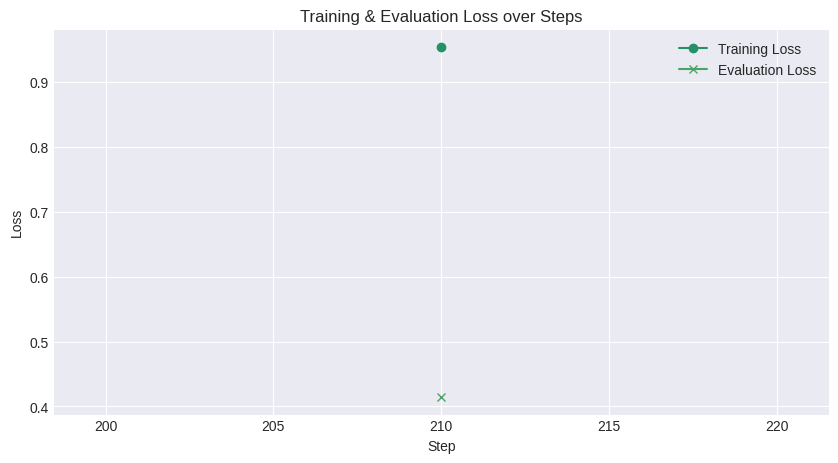

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot training loss
if 'train_loss' in log_df.columns:
    plt.plot(log_df["step"], log_df["train_loss"], label="Training Loss", marker='o')

# Plot evaluation loss
if 'eval_loss' in log_df.columns:
    plt.plot(log_df["step"], log_df["eval_loss"], label="Evaluation Loss", marker='x')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()


## 10.2 Accuracy

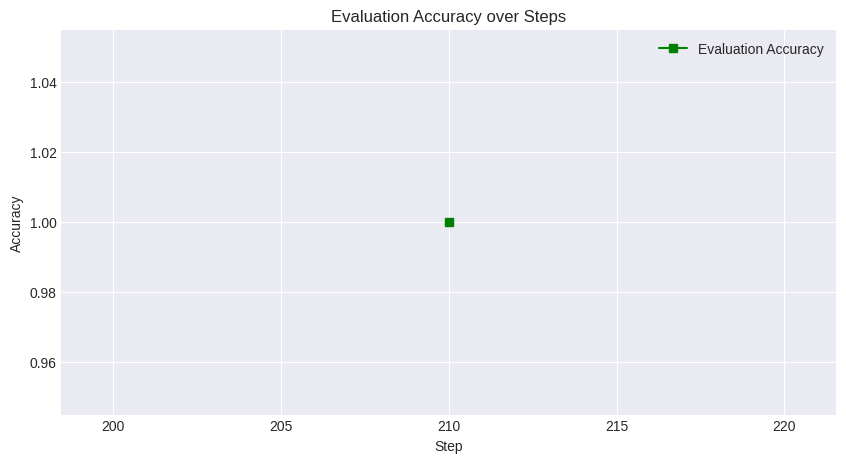

In [47]:
if "eval_accuracy" in log_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(log_df["step"], log_df["eval_accuracy"], label="Evaluation Accuracy", color='green', marker='s')
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()


## 10.3 Precision, Recall, F1

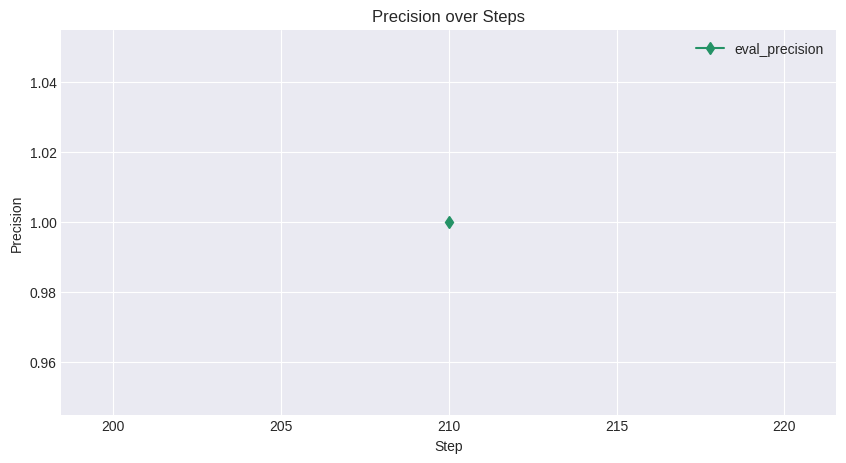

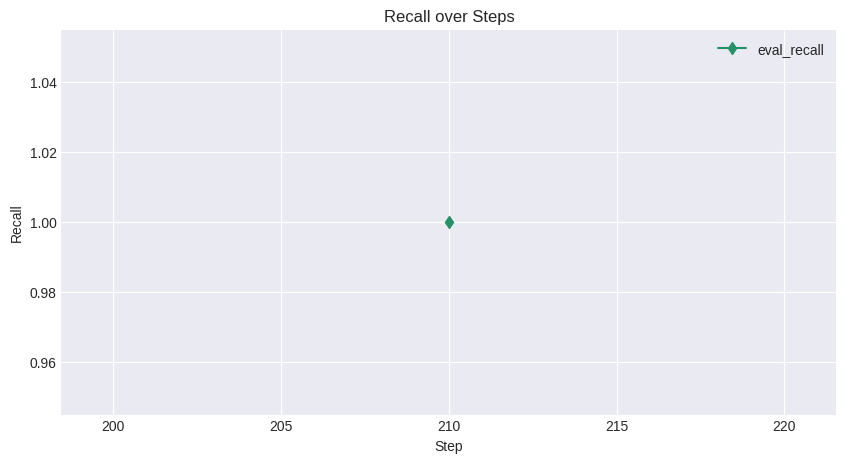

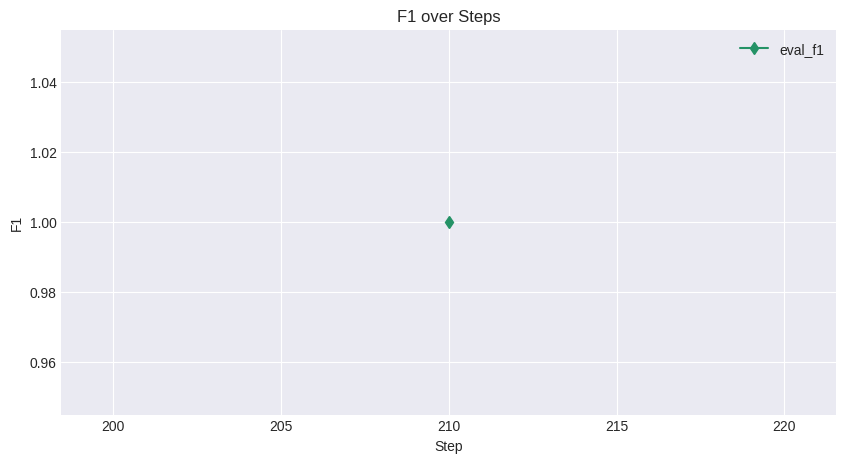

In [48]:
for metric in ["eval_precision", "eval_recall", "eval_f1"]:
    if metric in log_df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(log_df["step"], log_df[metric], label=metric, marker='d')
        plt.xlabel("Step")
        plt.ylabel(metric.split("_")[1].capitalize())
        plt.title(f"{metric.split('_')[1].capitalize()} over Steps")
        plt.legend()
        plt.grid(True)
        plt.show()


# 11. Saving the model

In [51]:
FINAL_DIR = "/kaggle/working/results/checkpoint-210" # choose any path

print(f"Saving model and processor to  {FINAL_DIR} …")
model.save_pretrained(FINAL_DIR)        # stores pytorch_model.bin, config.json, etc.
processor.save_pretrained(FINAL_DIR)    # stores preprocessor_config.json, vocab, …

print("✅  Everything saved!\n")

Saving model and processor to  /kaggle/working/results/checkpoint-210 …
✅  Everything saved!



# 12. Testing on Custom Data

In [53]:

from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import librosa, numpy as np, torch, os, pathlib, random
CUSTOM_WAV = "/kaggle/input/inputs/hurray.wav"  

assert pathlib.Path(CUSTOM_WAV).is_file(), "❌ WAV file not found!"

processor = Wav2Vec2Processor.from_pretrained(FINAL_DIR)
model     = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR)
device    = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# helper 
MAX_LEN = 44100  # 2.75 s @16 kHz  (same setting you used)

def predict_emotion(wav_path):
    speech, _ = librosa.load(wav_path, sr=16000)          # 16-kHz mono
    speech = speech[:MAX_LEN] if len(speech) > MAX_LEN else np.pad(speech, (0, MAX_LEN-len(speech)))
    inputs = processor(speech, sampling_rate=16000, return_tensors="pt",
                       padding=True, truncation=True, max_length=MAX_LEN)
    with torch.no_grad():
        logits = model(inputs.input_values.to(device)).logits
    pred = logits.argmax(dim=-1).item()
    return inverse_label_map[pred]

# run
print("  Emotion:", predict_emotion(CUSTOM_WAV))


  Emotion: Surprise


In [54]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import librosa, numpy as np, torch, os, pathlib, random
CUSTOM_WAV = "/kaggle/input/inputs/not well.wav"  

assert pathlib.Path(CUSTOM_WAV).is_file(), "❌ WAV file not found!"

processor = Wav2Vec2Processor.from_pretrained(FINAL_DIR)
model     = Wav2Vec2ForSequenceClassification.from_pretrained(FINAL_DIR)
device    = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# helper 
MAX_LEN = 44100  # 2.75 s @16 kHz  (same setting you used)

def predict_emotion(wav_path):
    speech, _ = librosa.load(wav_path, sr=16000)          # 16-kHz mono
    speech = speech[:MAX_LEN] if len(speech) > MAX_LEN else np.pad(speech, (0, MAX_LEN-len(speech)))
    inputs = processor(speech, sampling_rate=16000, return_tensors="pt",
                       padding=True, truncation=True, max_length=MAX_LEN)
    with torch.no_grad():
        logits = model(inputs.input_values.to(device)).logits
    pred = logits.argmax(dim=-1).item()
    return inverse_label_map[pred]

# run
print("  Emotion:", predict_emotion(CUSTOM_WAV))

  Emotion: fear
